In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('train_BRCpofr.csv')
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


Os dados podem ser econtrados [aqui](https://www.kaggle.com/datasets/shibumohapatra/customer-life-time-value?select=train_BRCpofr.csv)

id-Unique identifier of a customer  
gender-Gender of the customer   
area-Area of the customer   
qualification-Highest Qualification of the customer     
income-Income earned in a year (in rupees)  
marital_status-Marital Status of the customer {0:Single, 1: Married}    
vintage-No. of years since the first policy date    
claim_amount-Total Amount Claimed by the customer (in rupees)   
num_policies-Total no. of policies issued by the customer   
policy-Active policy of the customer    
type_of_policy-Type of active policy    
cltv- Customer lifetime value (Target Variable) 

# EDA

In [6]:
print(df.shape)
print(df.isna().sum())

(89392, 12)
id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64


In [7]:
for column in df.columns:
    if column == 'id' or column == 'claim_amount' or column == 'cltv':
        pass
    else:
        print(f'{column}:  {df[column].unique()}')

gender:  ['Male' 'Female']
area:  ['Urban' 'Rural']
qualification:  ['Bachelor' 'High School' 'Others']
income:  ['5L-10L' 'More than 10L' '2L-5L' '<=2L']
marital_status:  [1 0]
vintage:  [5 8 7 6 1 0 3 4 2]
num_policies:  ['More than 1' '1']
policy:  ['A' 'C' 'B']
type_of_policy:  ['Platinum' 'Gold' 'Silver']


Logo de cara imagino que para o type of policy eu possa usar o Ordinal Encoder, já que acredito que existirá uma relação positiva entre o tipo e o cltv. Claro que irei confirmar primeiro.     
Já para as outras variáveis categóricas, será necessário aprofundar em cada uma.

Uma das primeiras coisas que me chamou atenção quando abri o df foi a questão do income estar sendo passado como range, então primeiro irei explorar apenas ele para decidir como prosseguir

In [8]:
incomes_counts_policy = df.groupby(['income', 'type_of_policy'])['income'].count()
incomes_counts_policy

income         type_of_policy
2L-5L          Gold               4462
               Platinum          10908
               Silver             5788
5L-10L         Gold              12544
               Platinum          28610
               Silver            11562
<=2L           Gold                294
               Platinum           1042
               Silver              518
More than 10L  Gold               3286
               Platinum           7236
               Silver             3142
Name: income, dtype: int64

In [9]:
incomes_counts = df.groupby('income')['income'].count()
incomes_counts

income
2L-5L            21158
5L-10L           52716
<=2L              1854
More than 10L    13664
Name: income, dtype: int64

<AxesSubplot: xlabel='income'>

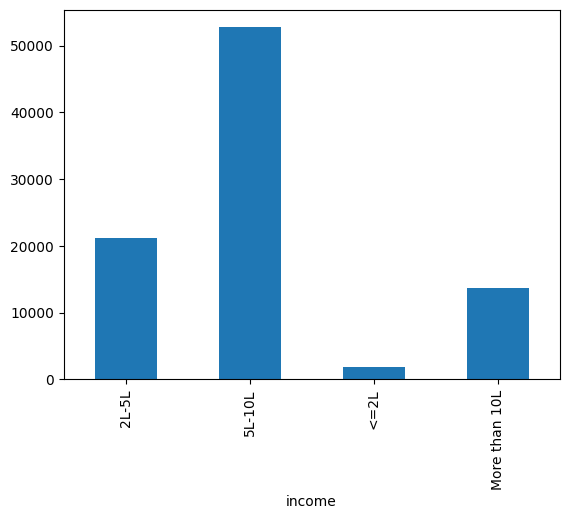

In [10]:
incomes_counts.plot(kind='bar')

<AxesSubplot: xlabel='income,type_of_policy'>

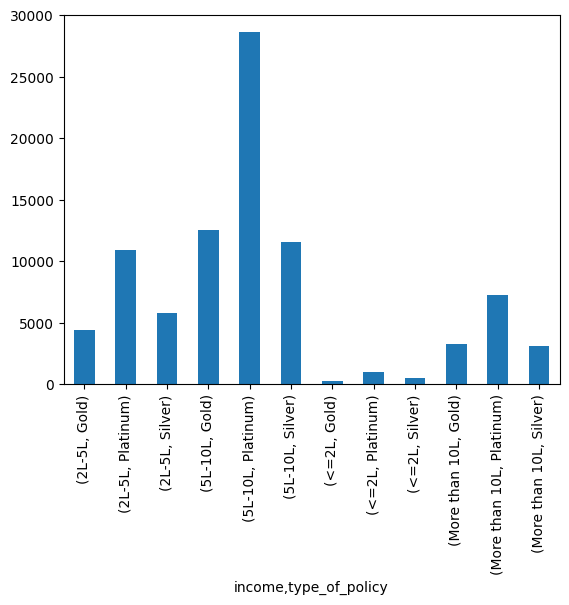

In [11]:
incomes_counts_policy.plot(kind='bar')

Podemos notar que em todos os o tipo seguro que predodomina é o platina.

In [12]:
cltv_by_income_policy = df.groupby(['income', 'type_of_policy'])['cltv'].sum()
cltv_by_income_policy

income         type_of_policy
2L-5L          Gold               491606004
               Platinum          1233512532
               Silver             590992884
5L-10L         Gold              1227635064
               Platinum          2762199048
               Silver            1021449360
<=2L           Gold                31918116
               Platinum           117362148
               Silver              57337164
More than 10L  Gold               294718320
               Platinum           654718764
               Silver             272749884
Name: cltv, dtype: int64

<AxesSubplot: xlabel='income,type_of_policy'>

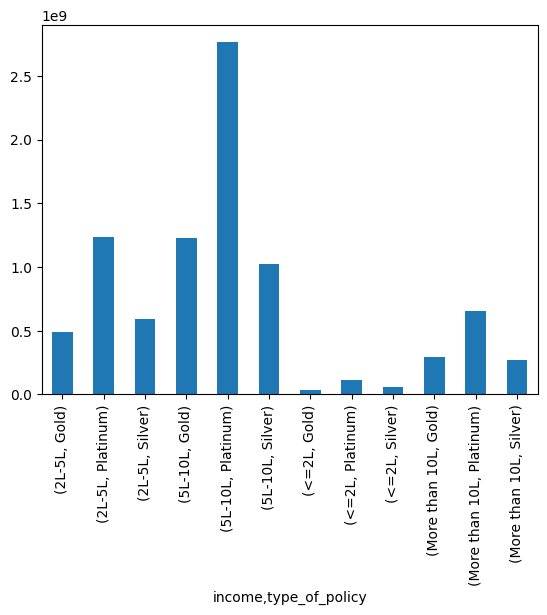

In [13]:
cltv_by_income_policy.plot(kind='bar')

Também como era de se imaginar são os que tem um cltv maior também.

In [14]:
df.groupby(['income', 'type_of_policy'])['cltv'].median()

income         type_of_policy
2L-5L          Gold              67518.0
               Platinum          69132.0
               Silver            67386.0
5L-10L         Gold              66240.0
               Platinum          66120.0
               Silver            64884.0
<=2L           Gold              66504.0
               Platinum          68874.0
               Silver            66174.0
More than 10L  Gold              65490.0
               Platinum          65670.0
               Silver            65634.0
Name: cltv, dtype: float64

<AxesSubplot: xlabel='income', ylabel='cltv'>

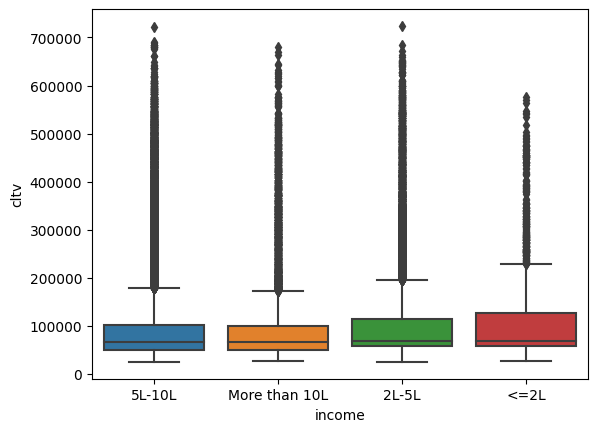

In [15]:
sns.boxplot(data=df, x='income', y='cltv')

<AxesSubplot: xlabel='income', ylabel='cltv'>

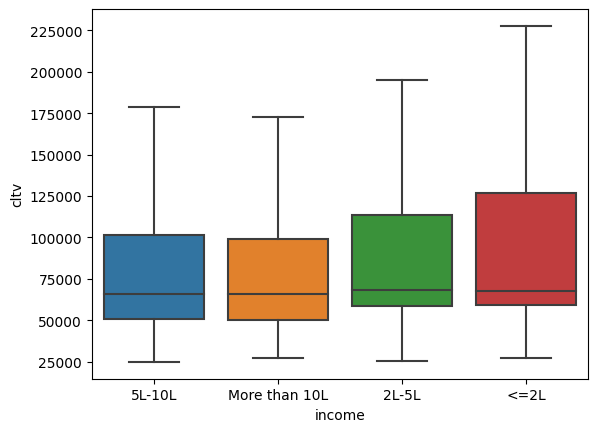

In [16]:
sns.boxplot(data=df, x='income', y='cltv', showfliers=False)

Incialmente os outliers assustam, mas podemos ficar mais "tranquilos" se levarmos em consideração à fórmula de como são encontrados os mesmos: [Q1 - k (Q3 - Q1), Q3 + k(Q3-Q1)]    
O que significa que a mediana junto com os quartis tem uma forte influencia.    
Como estamos falando de seguro eu presumo que isso ocorra porque a maior parte dos carros que circulam em qualquer cidade são populares, fazendo assim com que não tenham um custo de seguro tão elevado, o que faz com que existam médias realmente diferentes entre cada tipo de seguro ou renda, mas a mediana tende a se aproxima seguindo  a lógica de carros populares.
Mesmo assim vamos precisar verificar mais a fundo alguns valores.

In [17]:
np.percentile(df['cltv'], 75)

103440.0

In [18]:
df.query('cltv <= 103440.0')

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736
7,8,Female,Urban,High School,5L-10L,0,0,5473,More than 1,A,Silver,64128
...,...,...,...,...,...,...,...,...,...,...,...,...
89385,89386,Male,Urban,Bachelor,5L-10L,1,4,3138,More than 1,A,Gold,96672
89386,89387,Male,Urban,High School,5L-10L,1,0,5744,1,A,Platinum,59688
89387,89388,Male,Rural,High School,More than 10L,0,6,0,More than 1,B,Platinum,95736
89388,89389,Male,Urban,Bachelor,5L-10L,1,0,3897,More than 1,A,Platinum,67596


In [19]:
df.query('cltv > 103440.0')

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
5,6,Male,Rural,High School,More than 10L,1,1,0,1,C,Gold,348768
6,7,Female,Rural,Bachelor,5L-10L,1,6,0,More than 1,A,Gold,238920
13,14,Male,Urban,Bachelor,2L-5L,1,1,4615,More than 1,C,Silver,133344
19,20,Female,Urban,Bachelor,More than 10L,1,2,7541,More than 1,A,Platinum,110568
...,...,...,...,...,...,...,...,...,...,...,...,...
89380,89381,Male,Urban,High School,2L-5L,1,1,9885,More than 1,A,Silver,164004
89383,89384,Female,Rural,High School,5L-10L,0,8,6664,More than 1,A,Silver,199056
89384,89385,Female,Rural,Bachelor,2L-5L,0,7,0,More than 1,B,Platinum,171828
89389,89390,Female,Urban,Bachelor,5L-10L,0,4,3363,More than 1,B,Platinum,114120


Realmente podemos ver que usando o 3 quartil é possível notar que existem 3 vezes mais dados de um do que do outro. Vamos tentar realmente encontrar outliers.

Segundo pesquisa o valor médio de um seguro no Brasil está em 4014,31. Veja [aqui](https://investnews.com.br/economia/preco-de-seguro-de-carro-2022/#:~:text=Os%20números%20mostram%20que%2C%20em,para%20R%24%204.014%2C31.).   
Então vamos fazer algumas conversões de valores para descobrir o que é aceitável e o que não.   
No dia 03/03/2023 1 real é equivalente a 15,76 Rupia  indiana. 4014,31 * 15,76 = 63273,99.      
63273,99 * 12 = 759.287,88      
Usando esses valores como base podemos ter uma noção do que pode ser um outlier na vida real.

In [20]:
df.query('cltv > 750000')

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv


Seguindo a lógica usada, não parece realmente que existe algum outlier.

<AxesSubplot: xlabel='vintage', ylabel='claim_amount'>

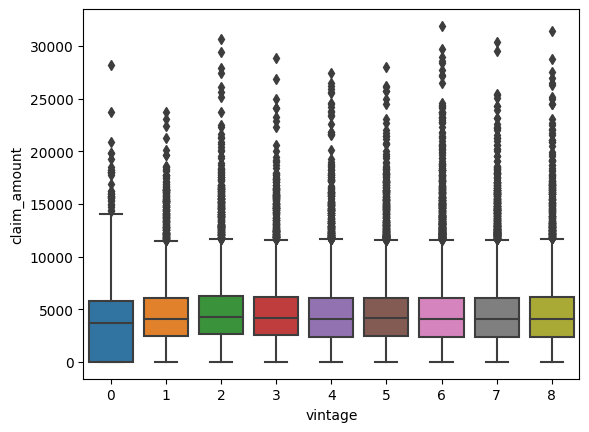

In [21]:
sns.boxplot(data=df, x='vintage', y='claim_amount')

Olhando os dados fiquei curioso se poderia haver algum outlier na questão de quanto a pessoa pegou de seguro, mas podemos ver que segue o mesmo padrão da outra análise

## Análise de distribuição/dispersão

In [22]:
qualitative_labels = df.drop(['vintage', 'claim_amount', 'cltv', 'id'], axis=1)
qualitative_labels.head()

,gender,area,qualification,income,marital_status,num_policies,policy,type_of_policy
0,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum
1,Male,Rural,High School,5L-10L,0,More than 1,A,Platinum
2,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum
3,Female,Rural,High School,5L-10L,0,More than 1,A,Platinum
4,Male,Urban,High School,More than 10L,1,More than 1,A,Gold


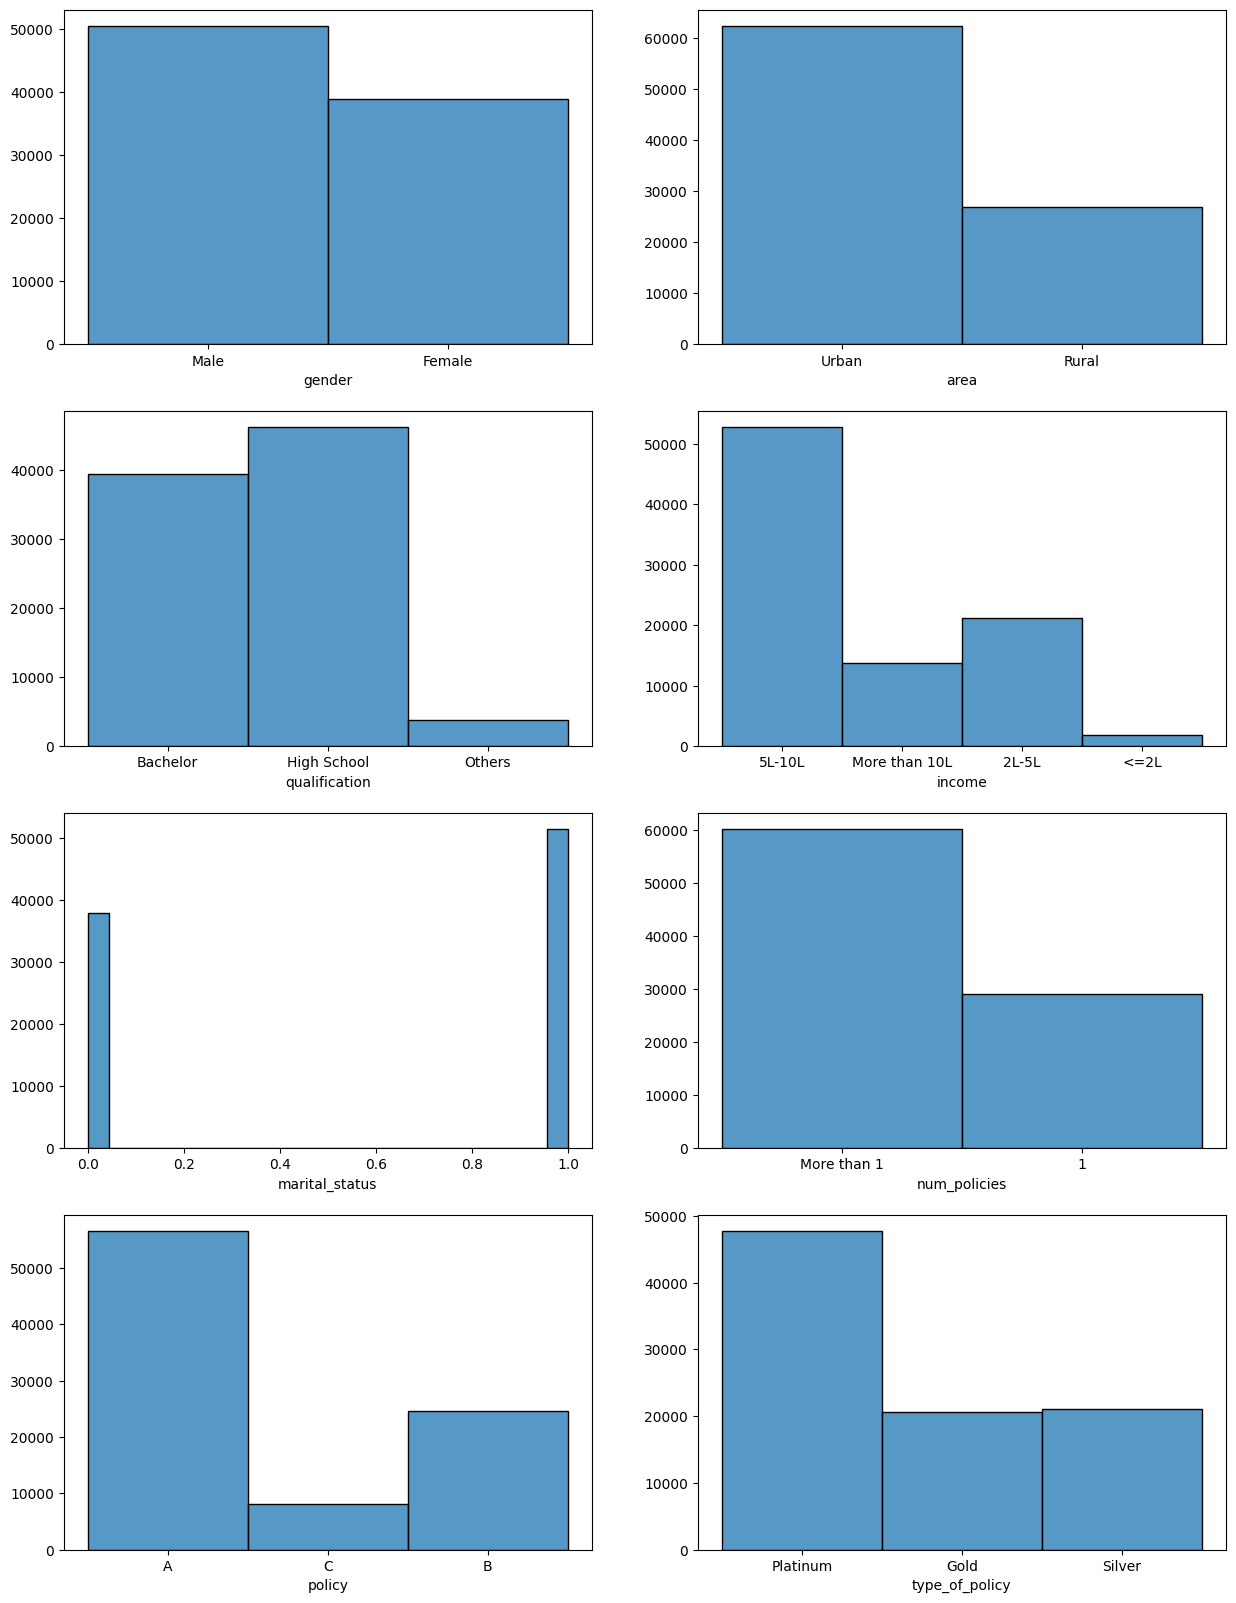

In [23]:
plt.figure(figsize=(15,20))
for i, column in enumerate(qualitative_labels.columns):
    plt.subplot(4, 2, i+1)
    sns.histplot(qualitative_labels[column])
    plt.ylabel('')

O único que realmente me chamou atenção foi o número de apólices, achei que 1 por pessoa seria o predominante. Mas levando em conta que a maioria das pessoas são cadas e que muitas vezes a família faz todos os seguros no nome de uma única pessoa, parece ser algo possível de se acreditar. Vamos dar uma breve verificada.

In [24]:
df.groupby(['num_policies', 'marital_status'])['num_policies'].count()

num_policies  marital_status
1             0                 10660
              1                 18469
More than 1   0                 27288
              1                 32975
Name: num_policies, dtype: int64

In [25]:
import math
from scipy.stats import norm

casados = 32975
solteiros = 27288
size = casados + solteiros

p1 = casados/size
p2 = solteiros/size

erro_padrao = math.sqrt((p1 * (1 - p1) / size) + (p2 * (1 - p2) / size))

z = (p1 - p2) / erro_padrao

alpha = 0.05

critical_value = norm.ppf(1 - alpha / 2)

abs(z) > critical_value

True

O código acima seria um cálculo de teste de hipótese, como não tenho um conhecimento profundo em estatística não sei dizer se realizei da maneira correta. Mas levando em conta a análise feita e o cálculo vou considerar que realmente existe uma diferença para pessoas casadas ou não e o número de apólices.

In [26]:
quantitative_labels = df[['vintage', 'claim_amount', 'cltv']]
quantitative_labels.head()

,vintage,claim_amount,cltv
0,5,5790,64308
1,8,5080,515400
2,8,2599,64212
3,7,0,97920
4,6,3508,59736


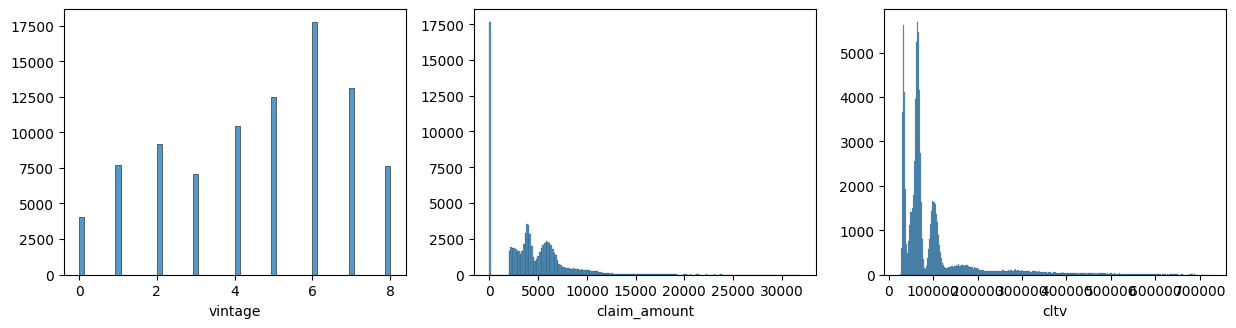

In [27]:
plt.figure(figsize=(15,20))
for i, column in enumerate(quantitative_labels.columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(quantitative_labels[column])
    plt.ylabel('')

Podemos ver que nenhum segue uma distribuição em forma de normal, pode ser interassante fazer alguma transformação para o treinamento do modelo. Mas isso vamos verificar mais a frente.

O que também podemos ver é que a maioria das pessoas não faz um claim, o que para a seguradora é algo bom

# Pré-processamento/Feature selection

In [28]:
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


A primeira coisa que irei fazer será retirar o vintage e o claim_amnount.   
Vamos pensar em um caso real. A empresa lhe contrata para que você faça a previsão do possível cltv de novos clientes, e diversas informações serão obtidas, mas não é possível se perguntar para o cliente quantos anos ele permanecerá sendo cliente. E também não conseguimos saber quanto que ele irá usar do seguro. Logo vemos que essas features se tratam do futuro.    
O que poderia ser uma opção é pegar os valores de antigas apólices caso o cliente tenha, mesmo que seja com outras seguradoras.

In [29]:
df = df.drop(['vintage', 'claim_amount'], axis=1)

In [30]:
replace = {
    'Male' : 0,
    'Female' : 1,
}

df['gender'] = df['gender'].map(replace)
df.head()

,id,gender,area,qualification,income,marital_status,num_policies,policy,type_of_policy,cltv
0,1,0,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum,64308
1,2,0,Rural,High School,5L-10L,0,More than 1,A,Platinum,515400
2,3,0,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum,64212
3,4,1,Rural,High School,5L-10L,0,More than 1,A,Platinum,97920
4,5,0,Urban,High School,More than 10L,1,More than 1,A,Gold,59736


In [31]:
replace = {
    'Silver' : 0,
    'Gold' : 1,
    'Platinum' : 2
}

df['type_of_policy'] = df['type_of_policy'].map(replace)
df.head()

,id,gender,area,qualification,income,marital_status,num_policies,policy,type_of_policy,cltv
0,1,0,Urban,Bachelor,5L-10L,1,More than 1,A,2,64308
1,2,0,Rural,High School,5L-10L,0,More than 1,A,2,515400
2,3,0,Urban,Bachelor,5L-10L,1,More than 1,A,2,64212
3,4,1,Rural,High School,5L-10L,0,More than 1,A,2,97920
4,5,0,Urban,High School,More than 10L,1,More than 1,A,1,59736


Já as outras variáveis vamos usar o one-hot-encoder. Mesmo usando ele nosso df não ficará tão grande.

In [32]:
from category_encoders.one_hot import OneHotEncoder

encoder = OneHotEncoder(cols=['area', 'qualification', 'income', 'num_policies', 'policy'])
encoder.fit(df)
df = encoder.transform(df)
df.head()

,id,gender,area_1,area_2,qualification_1,qualification_2,qualification_3,income_1,income_2,income_3,income_4,marital_status,num_policies_1,num_policies_2,policy_1,policy_2,policy_3,type_of_policy,cltv
0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,2,64308
1,2,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,2,515400
2,3,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,2,64212
3,4,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,2,97920
4,5,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,59736


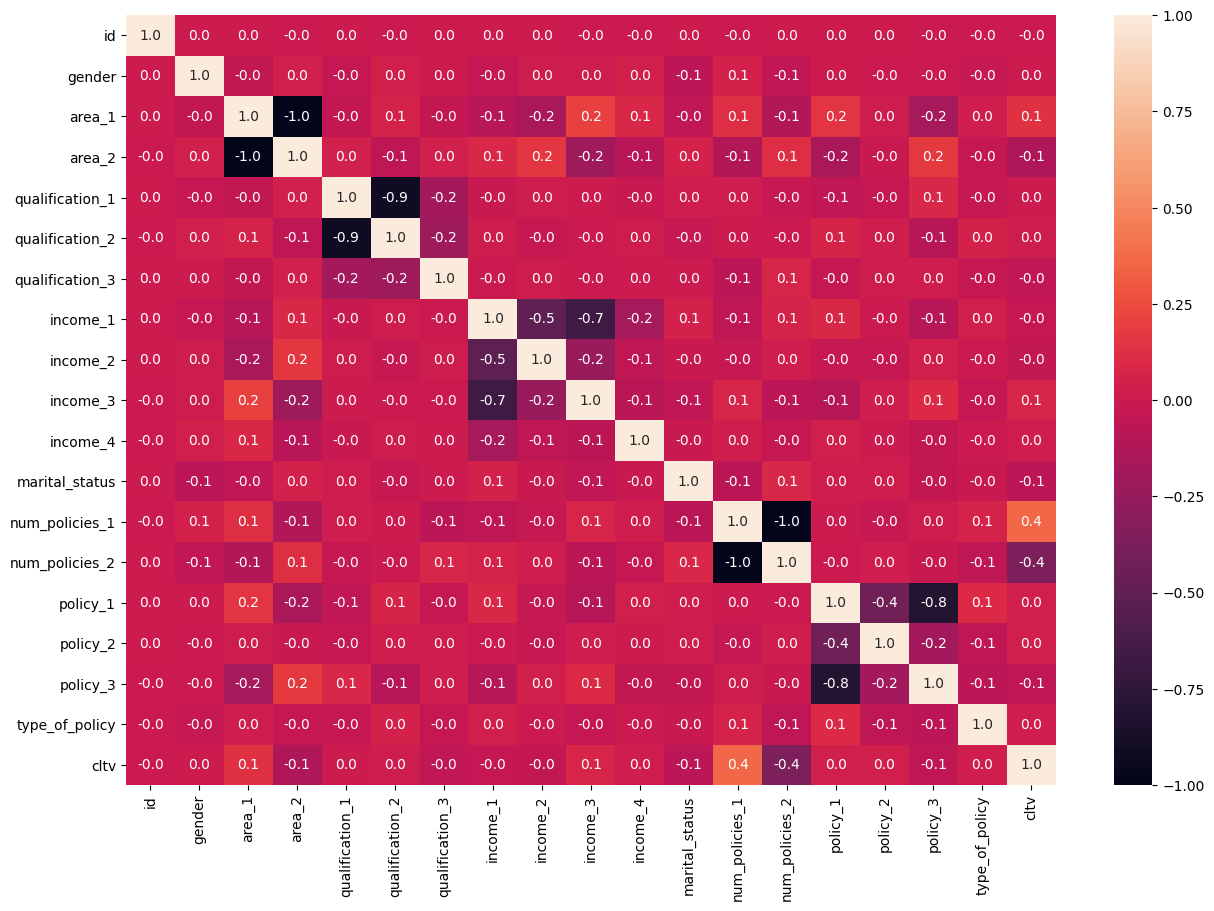

In [33]:
corr = df.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.1f')
plt.show()

Podemos ver que aparentemente nenhuma variável tem um correlação alta com o cltv

In [34]:
x = df.drop(['id', 'cltv'], axis=1)
y = df['cltv']

print(x.shape)
print(y.shape)

(89392, 17)
(89392,)


In [35]:
from sklearn.model_selection import train_test_split
import numpy as np

seed = 0
np.random.seed(seed)

raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.15)

In [36]:
print(raw_treino_x.shape)
print(raw_teste_x.shape)

(75983, 17)
(13409, 17)


# Treinando modelos

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Primeiro irei treinar todos os modelos sem mexer no parametros, e verificar os que melhor se adequam.

In [38]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), BayesianRidge(), RandomForestRegressor(), XGBRegressor()]

for model in models:
    steps = [('model', model)]
    pipe_model = Pipeline(steps)
    cv_results = cross_val_score(pipe_model, raw_treino_x, treino_y, scoring='r2')
    mean = cv_results.mean()
    std = cv_results.std()
    print(f'{str(model)} - Score [%.6f, %.6f]' % ((mean - 1.96 * std), (mean + 1.96 * std)))


LinearRegression() - Score [0.140577, 0.146903]
Ridge() - Score [0.140572, 0.146927]
Lasso() - Score [0.140574, 0.146926]
ElasticNet() - Score [0.102654, 0.107321]
BayesianRidge() - Score [0.140595, 0.146907]
RandomForestRegressor() - Score [0.130667, 0.144880]
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ..

# Tunning

Como podemos ver a regressão linear parece estar bem estável, mas também é notável que o XGBoost trouxe o range mais alto.  
Não coloquei nada para verificar o tempo de treio de cada uma, mas foi gritante que o random forest leva muito mais tempo que os outros modelos, seguido pelo xgboost.

In [44]:
from skopt import gp_minimize

def treinar_modelo(params):
    n_estimators = params[0]
    learn_rate = params[1]
    max_depth = params[2]
    min_child = params[3]
    subsample = params[4]


    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learn_rate, max_depth=max_depth, min_child_weight=min_child, subsample=subsample, n_jobs=6, gpu_id='0', tree_method='gpu_hist')
    model.fit(raw_treino_x, treino_y)
    predict = model.predict(raw_teste_x)
    return -r2_score(teste_y, predict)

space = [
    (100, 1000),
    (1e-3, 1e-1),
    (3, 10),
    (1, 60),
    (0.5, 1)
]

results = gp_minimize(treinar_modelo, space, random_state=0, verbose=True, n_calls=50, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.0348
Function value obtained: -0.1440
Current minimum: -0.1440
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.0902
Function value obtained: -0.1555
Current minimum: -0.1555
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.0644
Function value obtained: -0.1484
Current minimum: -0.1555
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.4851
Function value obtained: -0.1431
Current minimum: -0.1555
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.2543
Function value obtained: -0.1457
Current minimum: -0.1555
Iteration No: 6 started

In [45]:
results.x

[100, 0.1, 3, 1, 0.5]

In [46]:
xg_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5, n_jobs=6, gpu_id='0', tree_method='gpu_hist')
xg_model.fit(raw_treino_x, treino_y)
predict_xg = xg_model.predict(raw_teste_x)
r2_score(teste_y, predict_xg)

0.155869345475951

Bom, convenhamos que não chega a ser um resultado satisfatório ainda, mas é melhor do que a regressão linear.

In [47]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(teste_y, predict_xg)

51010.695326483146

In [57]:
plot = pd.DataFrame(teste_y)
plot['predict'] = predict_xg
plot['difference'] = plot['predict'] - plot['cltv']
plot

,cltv,predict,difference
15102,62220,101963.570312,39743.570312
80439,141900,132569.984375,-9330.015625
38719,70572,114488.304688,43916.304688
67258,67032,103941.007812,36909.007812
16758,50232,51622.882812,1390.882812
...,...,...,...
23401,32172,48338.445312,16166.445312
82338,78372,110833.078125,32461.078125
12781,96300,117962.890625,21662.890625
11782,563916,138118.421875,-425797.578125


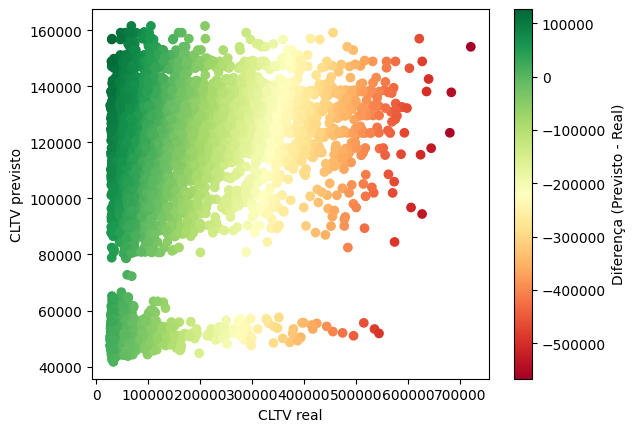

In [60]:
plt.scatter(data=plot, x='cltv', y='predict', c='difference', cmap='RdYlGn')
plt.xlabel('CLTV real')
plt.ylabel('CLTV previsto')

cbar = plt.colorbar()
cbar.ax.set_ylabel('Diferença (Previsto - Real)')

plt.show()

(array([4.000e+00, 4.000e+00, 1.100e+01, 1.900e+01, 4.300e+01, 6.500e+01,
        7.200e+01, 7.400e+01, 9.000e+01, 1.380e+02, 1.850e+02, 2.050e+02,
        2.010e+02, 2.340e+02, 4.490e+02, 1.261e+03, 4.882e+03, 3.325e+03,
        2.004e+03, 1.430e+02]),
 array([-566735.453125 , -532073.7984375, -497412.14375  , -462750.4890625,
        -428088.834375 , -393427.1796875, -358765.525    , -324103.8703125,
        -289442.215625 , -254780.5609375, -220118.90625  , -185457.2515625,
        -150795.596875 , -116133.9421875,  -81472.2875   ,  -46810.6328125,
         -12148.978125 ,   22512.6765625,   57174.33125  ,   91835.9859375,
         126497.640625 ]),
 <BarContainer object of 20 artists>)

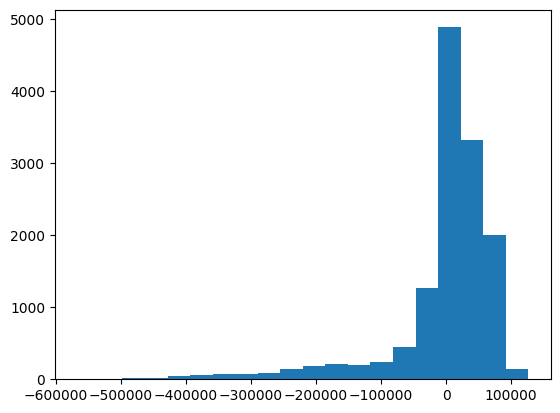

In [64]:
plt.hist(plot['difference'], bins=20)

Podemos ver que a parte de visualização não é muito o meu forte, ao mesmo tempo que é notável que o modelo não prevou corretamente nem metade dos valores.

(array([3.525e+03, 8.400e+02, 3.000e+00, 3.070e+02, 1.090e+03, 1.333e+03,
        2.800e+03, 2.003e+03, 1.378e+03, 1.300e+02]),
 array([ 41673.109375 ,  53656.7265625,  65640.34375  ,  77623.9609375,
         89607.578125 , 101591.1953125, 113574.8125   , 125558.4296875,
        137542.046875 , 149525.65625  , 161509.28125  ]),
 <BarContainer object of 10 artists>)

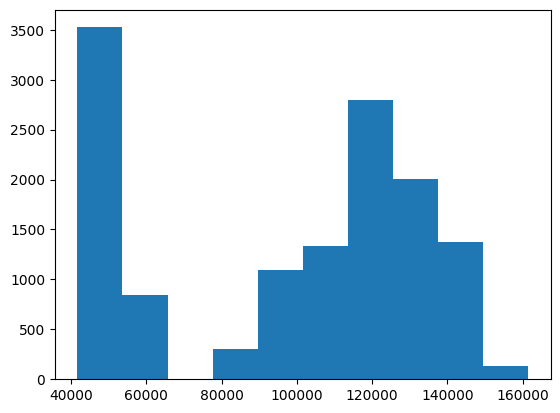

In [66]:
plt.hist(plot['predict'])

In [67]:
plot.max()

cltv          720804.000000
predict       161509.281250
difference    126497.640625
dtype: float64

In [68]:
plot.min()

cltv           26916.000000
predict        41673.109375
difference   -566735.453125
dtype: float64

In [70]:
plot.query('cltv >= 162000 or cltv <= 40000')

,cltv,predict,difference
88738,30252,51843.894531,21591.894531
55457,29220,55219.402344,25999.402344
57232,401088,128831.679688,-272256.320312
41612,31764,148853.734375,117089.734375
53209,194376,51770.578125,-142605.421875
...,...,...,...
44693,212988,126082.921875,-86905.078125
42816,34392,49348.921875,14956.921875
23401,32172,48338.445312,16166.445312
11782,563916,138118.421875,-425797.578125


O modelo também também se limitou a prever valores entre 41673.11 e 161509.28. Isso pode ter ocorrido devido a distrbuição dos dados e a quantidade de outliers que podem ter sidos levados em conta.

In [72]:
log_treino_y = np.log(treino_y)
log_teste_y = np.log(teste_y)

In [73]:
teste_model_xg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5, n_jobs=6, gpu_id='0', tree_method='gpu_hist')
teste_model_xg.fit(raw_treino_x, log_treino_y)
log_predict = teste_model_xg.predict(raw_teste_x)

In [74]:
r2_score(log_teste_y, log_predict)

0.3164933348495069

Aparentemente dobramos o desempenho do modelo apenas tratando os outliers.

In [76]:
plot['predict_log'] = np.exp(log_predict)
plot['difference_log'] = plot['predict_log'] - plot['cltv']
plot

,cltv,predict,difference,predict_log,difference_log
15102,62220,101963.570312,39743.570312,86738.421875,24518.421875
80439,141900,132569.984375,-9330.015625,103621.585938,-38278.414062
38719,70572,114488.304688,43916.304688,91934.539062,21362.539062
67258,67032,103941.007812,36909.007812,87335.976562,20303.976562
16758,50232,51622.882812,1390.882812,46790.437500,-3441.562500
...,...,...,...,...,...
23401,32172,48338.445312,16166.445312,45048.937500,12876.937500
82338,78372,110833.078125,32461.078125,89778.585938,11406.585938
12781,96300,117962.890625,21662.890625,95833.210938,-466.789062
11782,563916,138118.421875,-425797.578125,108143.789062,-455772.210938


(array([3.000e+00, 2.000e+00, 8.000e+00, 1.800e+01, 3.300e+01, 5.700e+01,
        7.600e+01, 6.800e+01, 8.800e+01, 1.190e+02, 1.720e+02, 1.960e+02,
        2.060e+02, 2.100e+02, 3.120e+02, 6.380e+02, 2.092e+03, 5.728e+03,
        3.151e+03, 2.320e+02]),
 array([-602193.7109375 , -567437.65820312, -532681.60546875,
        -497925.55273438, -463169.5       , -428413.44726562,
        -393657.39453125, -358901.34179688, -324145.2890625 ,
        -289389.23632812, -254633.18359375, -219877.13085938,
        -185121.078125  , -150365.02539062, -115608.97265625,
         -80852.91992188,  -46096.8671875 ,  -11340.81445312,
          23415.23828125,   58171.29101562,   92927.34375   ]),
 <BarContainer object of 20 artists>)

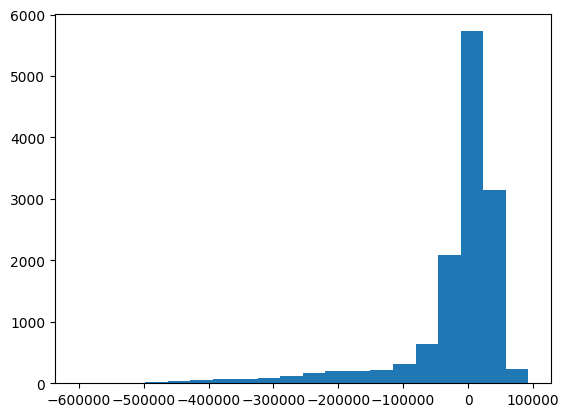

In [78]:
plt.hist(plot['difference_log'], bins=20)

Percebmos que a diferença diminuiu de maneira considerável usando log

(array([4284.,   82.,    0.,   10.,  727., 1755., 2570., 2425., 1414.,
         142.]),
 array([ 40143.6171875 ,  48620.6015625 ,  57097.58203125,  65574.5625    ,
         74051.546875  ,  82528.53125   ,  91005.515625  ,  99482.5       ,
        107959.4765625 , 116436.4609375 , 124913.4453125 ]),
 <BarContainer object of 10 artists>)

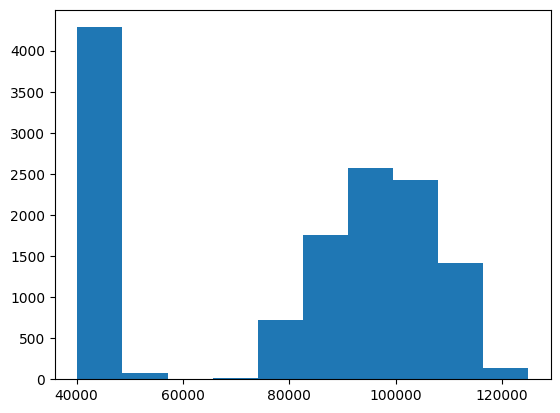

In [79]:
plt.hist(plot['predict_log'])

Já a distrbuiçaõ e o range de valores não parece ter mudado, e porque os resultados foram melhores?     
Acredito que isso se dê como já vimos lá em cima, por termos uma tendência a cltvs mais baixos com maior frequência, e foi exatamente o que o log nos ajudou, a buscar uma quantidade maior de valores menores.

In [81]:
plot.max()

cltv              720804.000000
predict           161509.281250
difference        126497.640625
predict_log       124913.445312
difference_log     92927.343750
dtype: float64

In [82]:
plot.min()

cltv               26916.000000
predict            41673.109375
difference       -566735.453125
predict_log        40143.617188
difference_log   -602193.710938
dtype: float64

E essa informação final comprova o que acabei de falar acima. O valor máximo que antes era previsto diminiu, já o valor mínimo sofreu uma pequena alteração mas uma maior aparição.

De qualquer forma não acredito que o modelo seria eficiente para se colocar em produção, seria necessário mais informações sobre cada cliente, ou talvez alguma técnica que não conheço ou não tenha abordado, como por exemplo criação de novas features com dados existentes, por mais que eu não acredite que faria uma grande diferença nesse caso.

Para dar continuidade ao projeto, irei considerar que o modelo foi aceito para produção e vou preparar como acredito que poderia ser disponibilizado.

In [83]:
import joblib

joblib.dump(teste_model_xg, 'cltv_predictor.joblib')

['cltv_predictor.joblib']